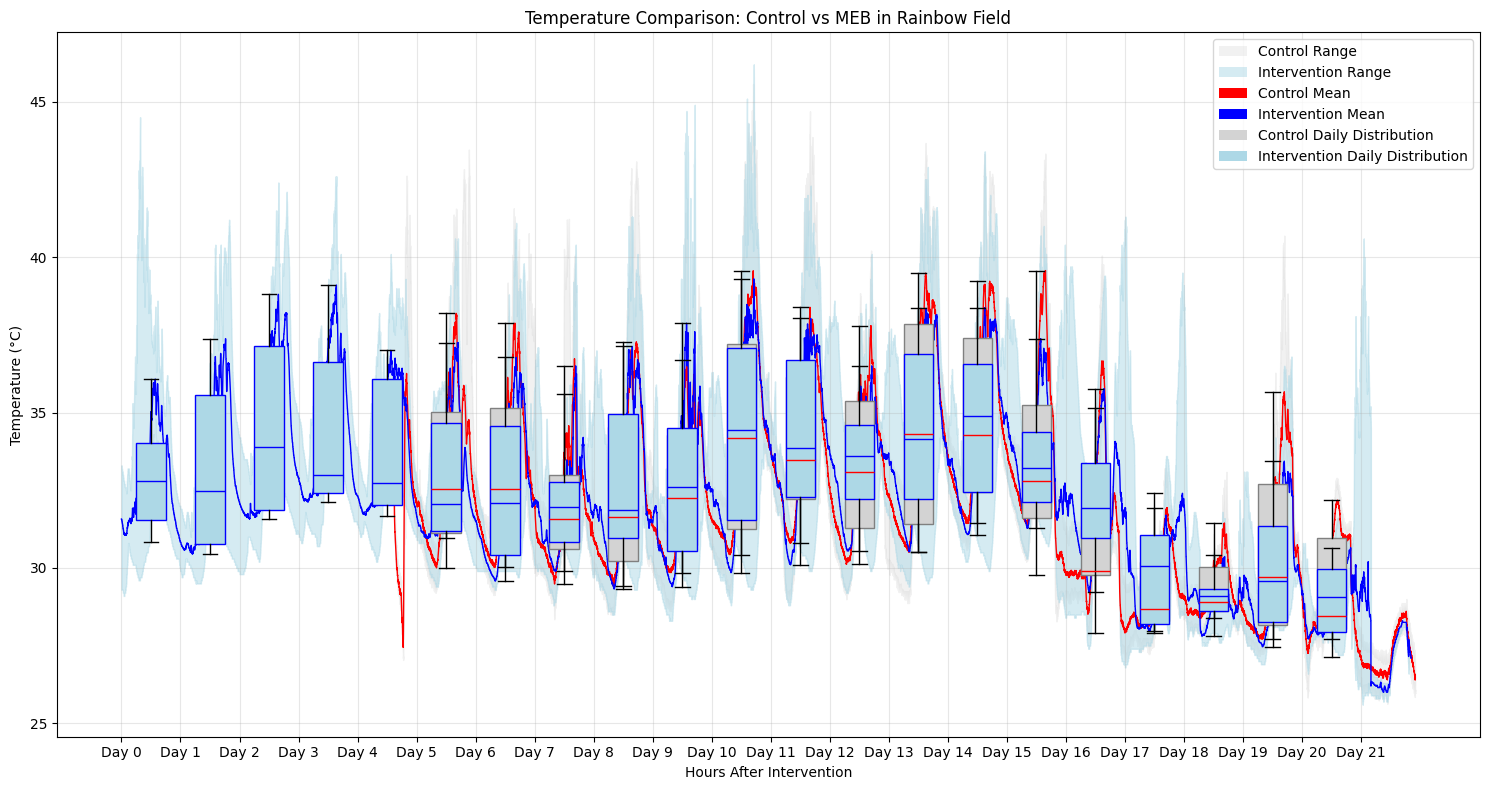

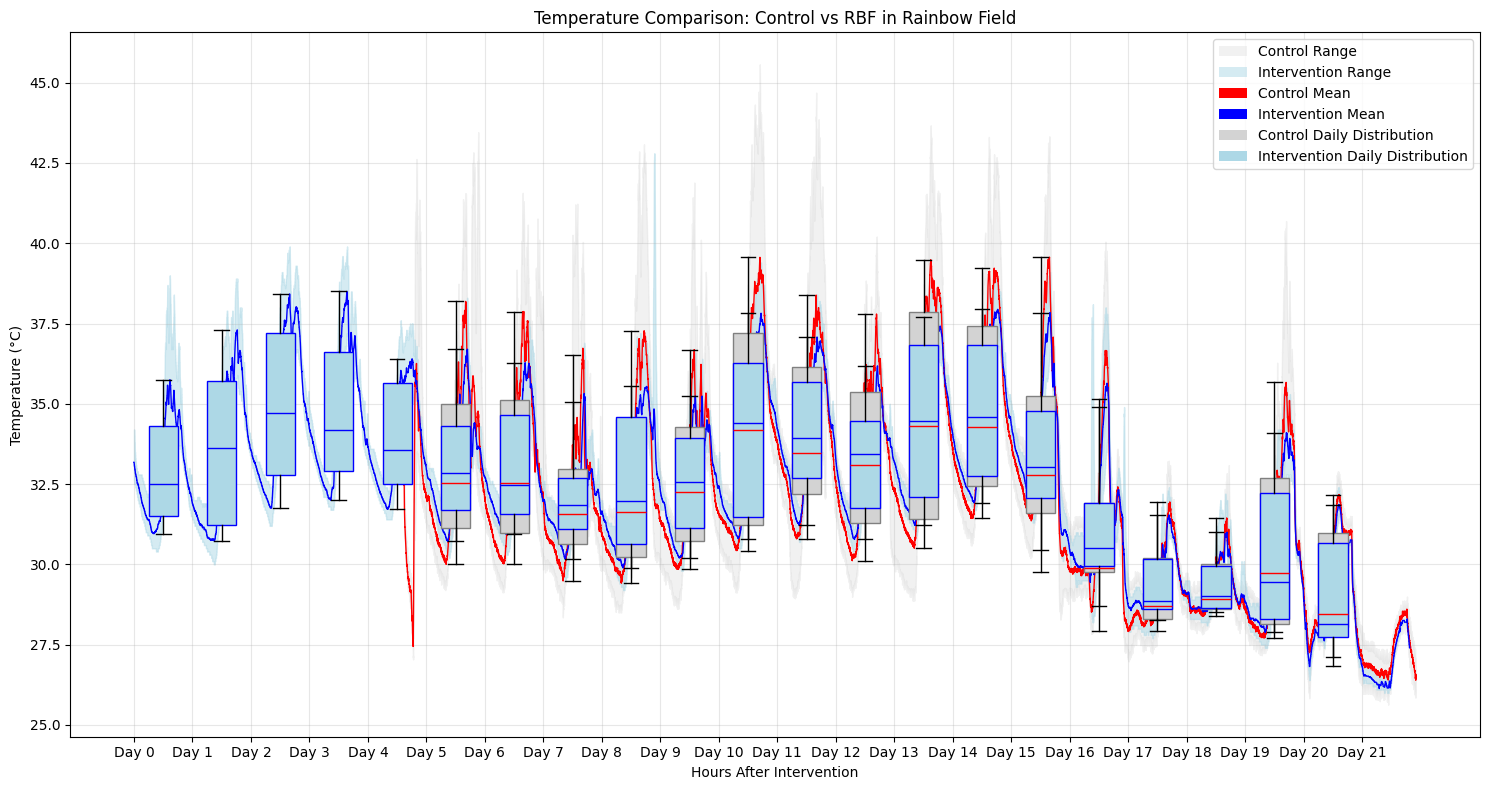

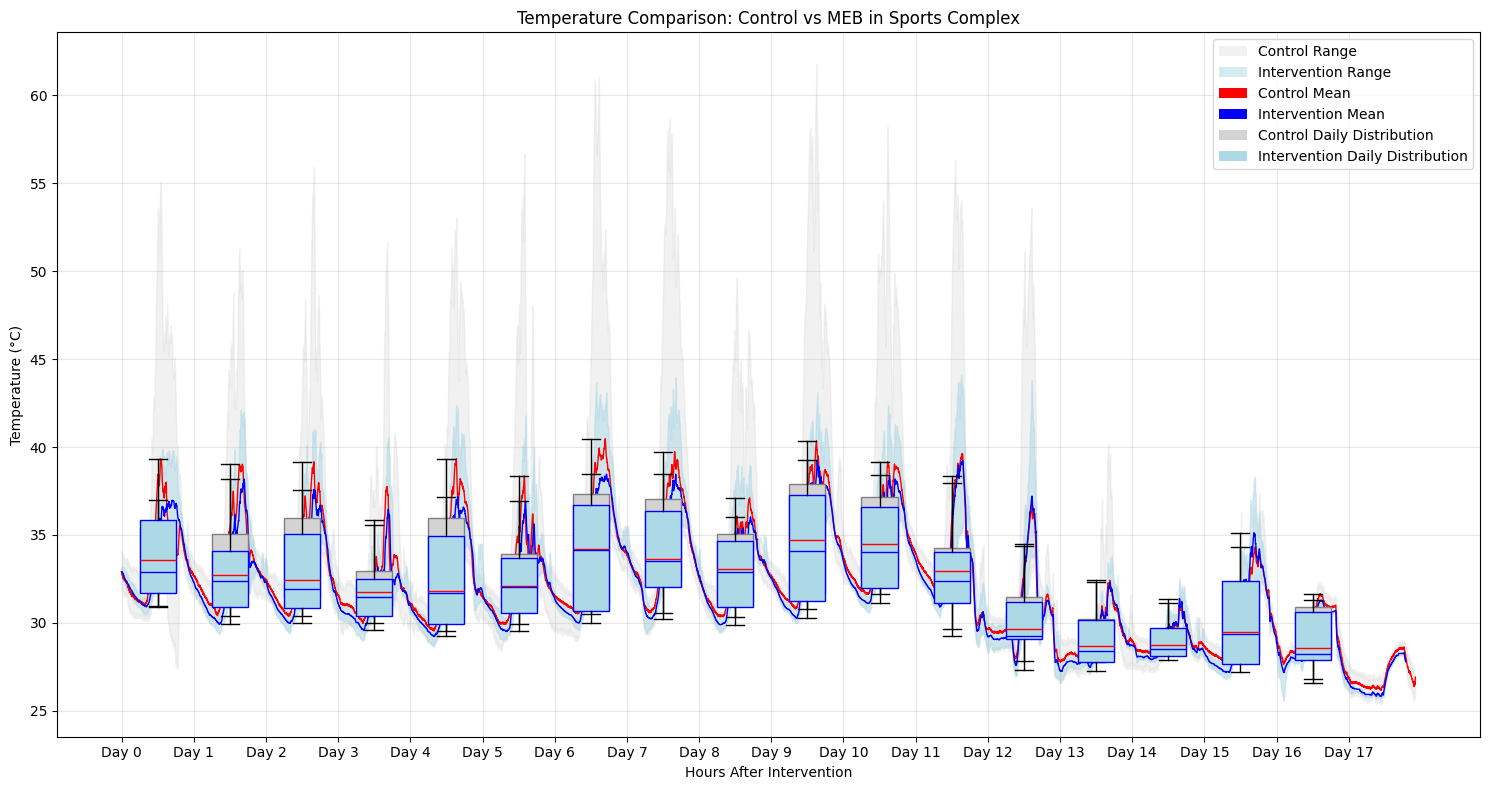

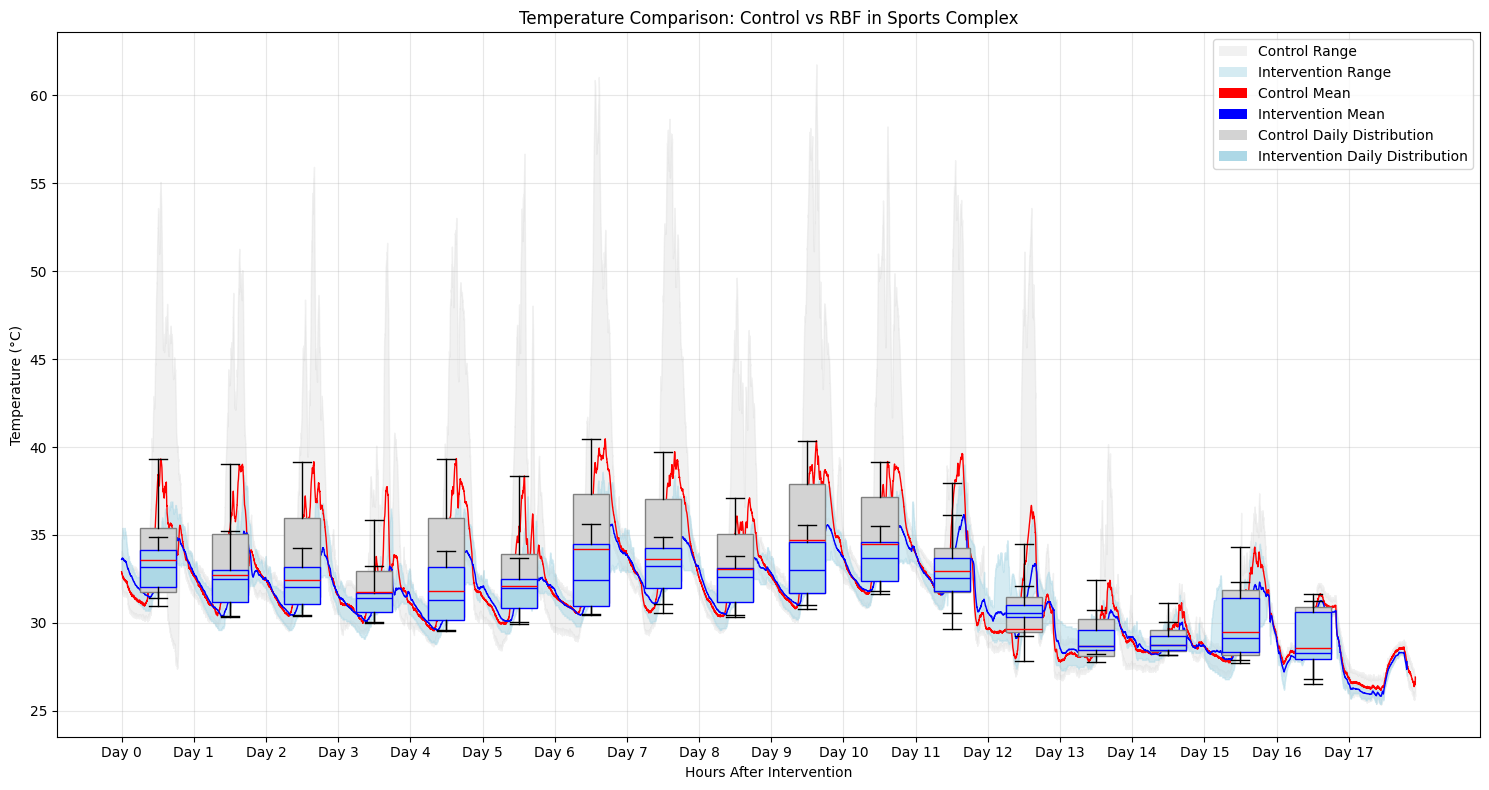

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

master_df = pd.read_csv('master_dataframe.csv', parse_dates=['DateTime'])
logger_flags_df = pd.read_csv('logger_flags.csv')

def create_hourly_comparison_plot(settlement, intervention_type='MEB'):
    control_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) &
        (logger_flags_df['Intervention'] == 'CONTROL')
    ]['Loggers'].tolist()

    intervention_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) &
        (logger_flags_df['Intervention'] == intervention_type)
    ]['Loggers'].tolist()

    intervention_start = pd.to_datetime(
        logger_flags_df[
            (logger_flags_df['Settlement'] == settlement) &
            (logger_flags_df['Intervention'] == intervention_type)
        ]['Intervention_Start'].iloc[0]
    )

    master_df['DateTime'] = pd.to_datetime(master_df['DateTime'])
    post_intervention_df = master_df[master_df['DateTime'] >= intervention_start].copy()
    post_intervention_df['Hours_After_Intervention'] = (
        post_intervention_df['DateTime'] - intervention_start
    ).dt.total_seconds() / 3600

    def calculate_hourly_stats(loggers, df):
        hourly_stats = pd.DataFrame()

        logger_data = df[loggers]
        hourly_stats['max'] = logger_data.max(axis=1)
        hourly_stats['min'] = logger_data.min(axis=1)
        hourly_stats['mean'] = logger_data.mean(axis=1)
        hourly_stats['std'] = logger_data.std(axis=1)
        hourly_stats['Hours_After_Intervention'] = df['Hours_After_Intervention']

        return hourly_stats

    control_stats = calculate_hourly_stats(control_loggers, post_intervention_df)
    intervention_stats = calculate_hourly_stats(intervention_loggers, post_intervention_df)

    plt.figure(figsize=(15, 8))

    plt.fill_between(control_stats['Hours_After_Intervention'],
                     control_stats['max'],
                     control_stats['min'],
                     alpha=0.3,
                     color='lightgray',
                     label='Control Range')

    plt.fill_between(intervention_stats['Hours_After_Intervention'],
                     intervention_stats['max'],
                     intervention_stats['min'],
                     alpha=0.5,
                     color='lightblue',
                     label='Intervention Range')

    plt.plot(control_stats['Hours_After_Intervention'],
             control_stats['mean'],
             color='red',
             label='Control Mean',
             linewidth=1)

    plt.plot(intervention_stats['Hours_After_Intervention'],
             intervention_stats['mean'],
             color='blue',
             label='Intervention Mean',
             linewidth=1)

    box_width = 12
    for day in range(int(max(control_stats['Hours_After_Intervention']) / 24)):
        hour = day * 24

        control_day = control_stats[
            (control_stats['Hours_After_Intervention'] >= hour) &
            (control_stats['Hours_After_Intervention'] < hour + 24)
        ]
        intervention_day = intervention_stats[
            (intervention_stats['Hours_After_Intervention'] >= hour) &
            (intervention_stats['Hours_After_Intervention'] < hour + 24)
        ]

        if len(control_day) > 0:
            plt.boxplot(control_day['mean'],
                       positions=[hour + 12],
                       widths=box_width,
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgray', color='gray'),
                       medianprops=dict(color='red'),
                       showfliers=False)

        if len(intervention_day) > 0:
            plt.boxplot(intervention_day['mean'],
                       positions=[hour + 12],
                       widths=box_width,
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', color='blue'),
                       medianprops=dict(color='blue'),
                       showfliers=False)

    plt.xlabel('Hours After Intervention')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Comparison: Control vs {intervention_type} in {settlement}')

    legend_elements = [
        Patch(facecolor='lightgray', alpha=0.3, label='Control Range'),
        Patch(facecolor='lightblue', alpha=0.5, label='Intervention Range'),
        Patch(facecolor='red', label='Control Mean'),
        Patch(facecolor='blue', label='Intervention Mean'),
        Patch(facecolor='lightgray', label='Control Daily Distribution'),
        Patch(facecolor='lightblue', label='Intervention Daily Distribution')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    xticks = np.arange(0, max(control_stats['Hours_After_Intervention']), 24)
    plt.xticks(xticks, [f'Day {int(x/24)}' for x in xticks])

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

settlements = ['Rainbow Field', 'Sports Complex']
intervention_types = ['MEB', 'RBF']

for settlement in settlements:
    for intervention_type in intervention_types:
        create_hourly_comparison_plot(settlement, intervention_type)